# Mixture of Compound Gaussians 

Compound Gaussian is a more general class of distributions that can be expressed as

$$X = \mu + \sqrt{\tau} A g$$

with $\tau \geq 0$ random variable, $g\sim \mathcal{N}(0, I)$, $AA^T=\Sigma$ 

$X_i|\tau=\tau_i \sim \mathcal{N}(\mu_j,\tau_i \Sigma_j)$

We load the libraries

In [1]:
import numpy as np
import random 
import pandas as pd
import os
import time
import csv 
import warnings

# MATH and STATS:
import math
from scipy.stats import t
from scipy.stats import multivariate_normal
from scipy.special import gamma

# PLOT:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D
from plotnine import *
from plotnine.data import *
%matplotlib inline

# SKLEARN:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
import sklearn.datasets
from sklearn import metrics # AMII and ARI
from sklearn import decomposition #PCA

import umap

In [2]:
from frem import *

In [3]:
def import_subset(dataset, labels, selected_cat, n_pca, n_sample):
    subset_labels = np.zeros((n_sample*len(selected_cat), ))

    i = 1    

    data_label = dataset.loc[selected_cat[0]==labels]
    sample = random.sample(range(data_label.shape[0]), n_sample)
    subset_data = data_label.iloc[sample, :]
    subset_labels[(n_sample*(i-1)):(n_sample*i)] = selected_cat[0]

    for cat in selected_cat[1:]:
        i += 1
        data_label = dataset.loc[labels==cat]
        sample = random.sample(range(data_label.shape[0]), n_sample)
        subset_data = pd.concat([subset_data, data_label.iloc[sample, :]])
        subset_labels[(n_sample*(i-1)):(n_sample*i)] = cat  

    pca = decomposition.PCA(n_components = n_pca)
    pca.fit(subset_data)
    return pca.transform(subset_data), np.array(subset_labels).astype(int), subset_data


In [97]:
#%load_ext rpy2.ipython # to use R code, need to install rpy2

### To compare with t-EM (code in R)

In [58]:
%%R 
#to run R in this cell, installing rpy2 needed
library("EMMIXskew")

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R -i mnist_pca -o est_labels

res = EmSkew(mnist_pca, 2, distr="mvt")
est_labels = res$clust

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels, est_labels))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels, est_labels))

In [ ]:
%%R -i mnist_pca_2 -o est_labels_2

res_2 = EmSkew(mnist_pca_2, 2, distr="mvt")
est_labels_2 = res_2$clust

In [ ]:
print('AMI: ', metrics.adjusted_mutual_info_score(mnist_labels_2, est_labels_2))
print('ARI: ', metrics.adjusted_rand_score(mnist_labels_2, est_labels_2))

### NORB dataset

In [4]:
from smallnorb import *

Import all data (don't run multiple times)

In [5]:
NORB = SmallNORBDataset(dataset_root='./data/')

datiss = NORB._parse_NORB_dat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat')
NORB_datos = np.reshape(datiss, (48600, 9216,)) #each image in a row
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 865598.17it/s]


In [6]:
NORB_datos_lt = NORB_datos[::2, :] #only left image

NORB_labels = NORB._parse_NORB_cat_file('data/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat')

Loading categories...: 100%|██████████| 24300/24300 [00:00<00:00, 557143.41it/s]


Select subset of categories, number of samples and PCA 

In [7]:
np.random.seed(44)
random.seed(44)

#categories = ['human', 'airplane', 'truck', 'car']
selected_cat = [1, 2, 3, 4]
n_sample = 400
n_pca = 30

#NORB_datos_lt -= np.mean(NORB_datos_lt, axis = 0)
#NORB_datos_lt /= np.std(NORB_datos_lt, axis = 0)
#nueva = NORB_datos_lt - NORB_datos_lt.mean(axis=1).reshape(-1, 1) + 127.5

NORB_datos_lt = pd.DataFrame(NORB_datos_lt)

NORB_pca, NORB_labels_sel, NORB_raw = import_subset(NORB_datos_lt, NORB_labels, selected_cat, 30, 400)

Plot to check

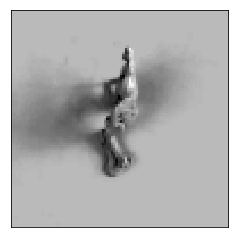

In [11]:
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,   
    left=False,
    labelleft=False,
    labelbottom=False)
plt.imshow(np.reshape(1-np.array(NORB_raw.iloc[100])/255, (96, 96)), cmap="binary")

C:\Users\roizmanv\anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


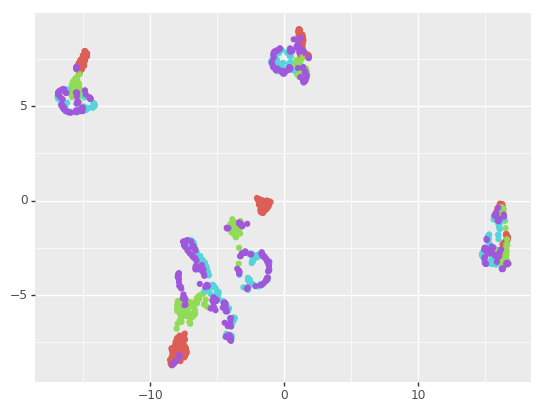

<ggplot: (103513126548)>

In [8]:
embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(NORB_pca)

label = pd.Series(NORB_labels_sel)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['real labels'] = label.astype(str)
ggplot(aes(x='A', y='B', color='real labels'), data=em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

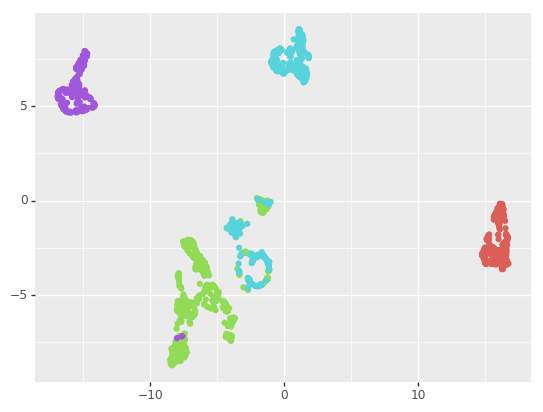

<ggplot: (-9223371888911463578)>

In [13]:
kmeans = KMeans(n_clusters=4).fit(NORB_pca)
em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
em['label'] = pd.Series(NORB_labels_sel)
ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [14]:
print('AMI kmeans: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, kmeans.labels_))
print('ARI kmeans: ', metrics.adjusted_rand_score(NORB_labels_sel, kmeans.labels_))

C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


AMI kmeans:  0.0012046114021813364
ARI kmeans:  0.0015266393680895723


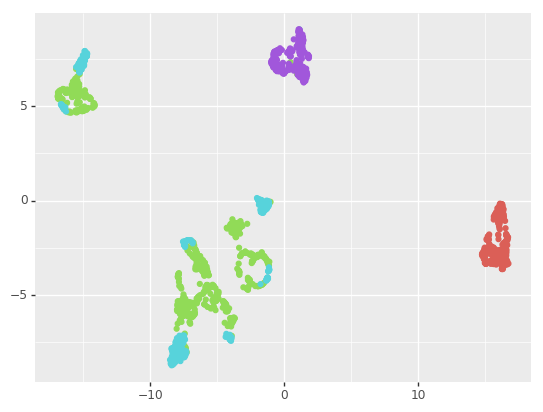

<ggplot: (147940118953)>

In [15]:
gmm = GaussianMixture(n_components=4).fit(NORB_pca)
labels_gmm = gmm.predict(NORB_pca)
em['gmm'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='gmm'))+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

In [16]:
print('AMI GMM: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, labels_gmm))
print('ARI GMM: ', metrics.adjusted_rand_score(NORB_labels_sel, labels_gmm))

C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


AMI GMM:  0.16440282357422592
ARI GMM:  0.14702761241662918


In [9]:
nrep = 15
frem_AMI_NORB = np.zeros((nrep, ))
frem_ARI_NORB = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(4, NORB_pca, 300, False, 1, 20)
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_NORB[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_NORB[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI_NORB))
print(np.median(frem_ARI_NORB))
print(np.quantile(frem_AMI_NORB, 0.25))
print(np.quantile(frem_ARI_NORB, 0.25))
print(np.quantile(frem_AMI_NORB, 0.75))
print(np.quantile(frem_ARI_NORB, 0.75))

convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  140


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.49972283971531234
0.4778899514998958
0.49972283971531234
0.4778899514998958
0.49972283971531234
0.4778899514998958


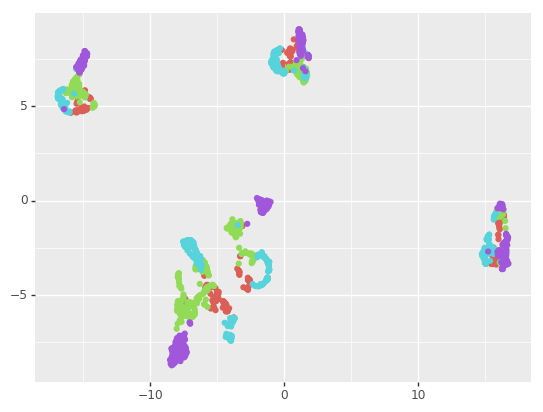

<ggplot: (147938009131)>

In [18]:
cond_prob = compute_condition_prob_matrix(NORB_pca, theta_estimated_1)
labels_cg = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated'))+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

In [36]:
np.savetxt("NORB_pca.csv", NORB_pca, delimiter=",")
np.savetxt("NORB_raw.csv", NORB_raw, delimiter=",")
np.savetxt("NORB_labels_sel.csv", NORB_labels_sel, delimiter=",")

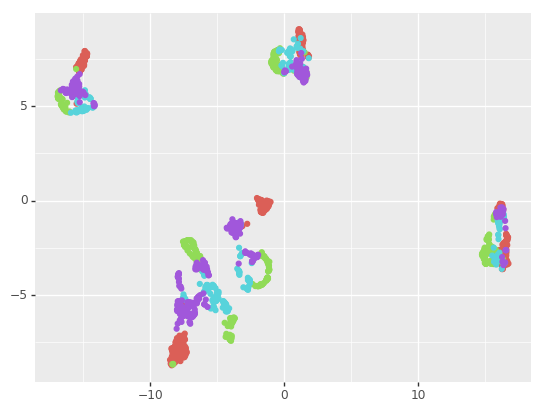

<ggplot: (138186802650)>

In [253]:
rlabels = pd.read_csv("est_labels.csv").values[:,0]
em['tmm'] = pd.Series(rlabels.astype(str))
ggplot(em, aes(x='A',y='B',color='tmm'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [91]:
print('AMI: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, rlabels))
print('ARI: ', metrics.adjusted_rand_score(NORB_labels_sel, rlabels))

NameError: name 'rlabels' is not defined

In [33]:
print('AMI: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, labels_cg))
print('ARI: ', metrics.adjusted_rand_score(NORB_labels_sel, labels_cg))

C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


AMI:  0.40290778241769953
ARI:  0.3297639653565996


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


0.323327789125502


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


AMI:  -0.0012817763567079014
AMI:  -0.0010496519153823177


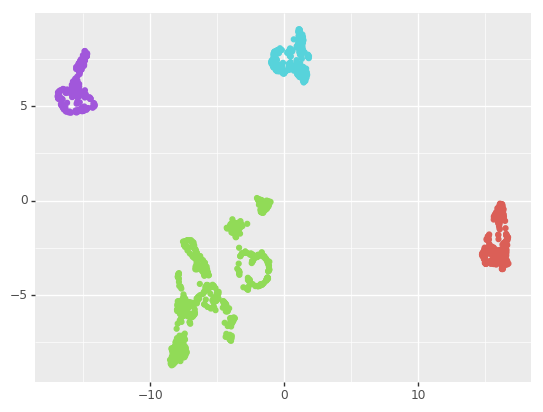

<ggplot: (-9223371875227102513)>

In [23]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters = 4, affinity= "nearest_neighbors", n_neighbors=30)
spectral.fit(NORB_pca)
print(sklearn.metrics.silhouette_score(NORB_pca, spectral.labels_))
print('AMI: ', metrics.adjusted_mutual_info_score(NORB_labels_sel, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(NORB_labels_sel, spectral.labels_.astype(str)))
em['spec'] = pd.Series(spectral.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='spec'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

## 20newsgroup

In [10]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['sci.space',
    'talk.religion.misc',
    'rec.motorcycles',
    'comp.windows.x']

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=44)

labels = dataset.target
true_k = np.unique(labels).shape[0]

vectorizer = TfidfVectorizer(max_df=0.5, max_features=150,
                                 min_df=2, stop_words='english')

X = vectorizer.fit_transform(dataset.data)

XXdata  = pd.DataFrame(X.toarray())

In [11]:
news_pca, news_labels, news_raw = import_subset(XXdata, labels, [0,1,2,3], 100, 500)

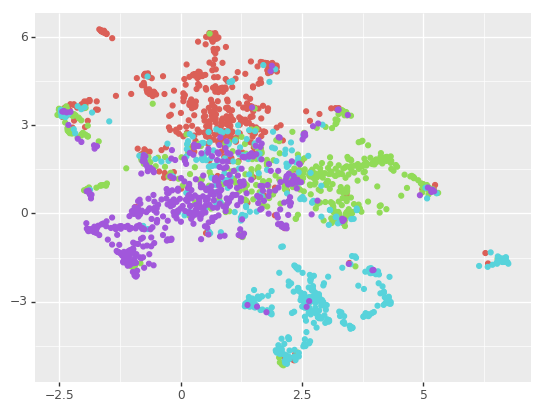

<ggplot: (103510820840)>

In [12]:
embedding = umap.UMAP(metric='euclidean', n_neighbors=20, min_dist=0.1).fit_transform(news_pca)
#embedding = umap.UMAP(random_state = 44, metric='euclidean').fit_transform(news_pca)

label = pd.Series(news_labels)
em = pd.DataFrame(embedding, columns=['A','B']) 
em['real labels'] = label.astype(str)
ggplot(aes(x='A', y='B', color='real labels'), data=em)+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

0.04154781828425265


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


AMI:  0.166589495301611
AMI:  0.09875868549879706


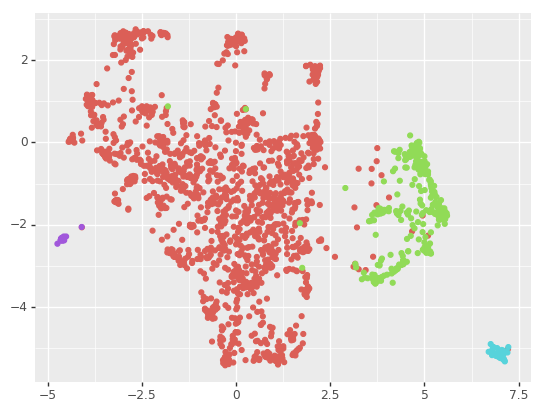

<ggplot: (-9223371875227627653)>

In [36]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters = 4, affinity= "nearest_neighbors", n_neighbors=11)
spectral.fit(news_pca)
print(sklearn.metrics.silhouette_score(news_pca, spectral.labels_))
print('AMI: ', metrics.adjusted_mutual_info_score(news_labels, spectral.labels_.astype(str)))
print('AMI: ', metrics.adjusted_rand_score(news_labels, spectral.labels_.astype(str)))
em['spec'] = pd.Series(spectral.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='spec'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

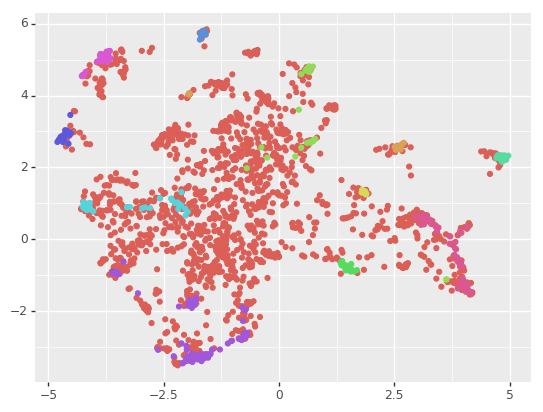

<ggplot: (-9223371862370926725)>

In [29]:
import hdbscan

hdbis = hdbscan.HDBSCAN(min_cluster_size=10)
hdbis.fit(news_pca)
em['hdbs'] = hdbis.labels_.astype(str)
ggplot(aes(x='A', y='B', color='hdbs'), data=em)+geom_point()+ scale_color_discrete(guide=False) +xlab("")+ylab("")

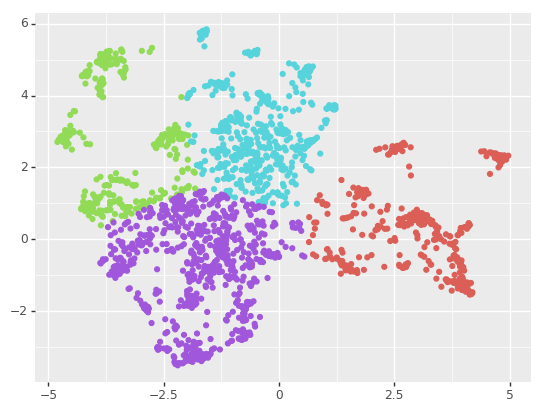

<ggplot: (174606766824)>

In [20]:
kmeans = KMeans(n_clusters=4).fit(embedding)
em['kmeans'] = pd.Series(kmeans.labels_.astype(str))
ggplot(em, aes(x='A',y='B',color='kmeans'))+geom_point()+ scale_color_discrete(guide=False)+ylab("")+xlab("")

In [21]:
print('AMI: ', metrics.adjusted_mutual_info_score(news_labels, kmeans.labels_))
print('ARI: ', metrics.adjusted_rand_score(news_labels, kmeans.labels_))

AMI:  0.352352161299965
ARI:  0.3675757676959137


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


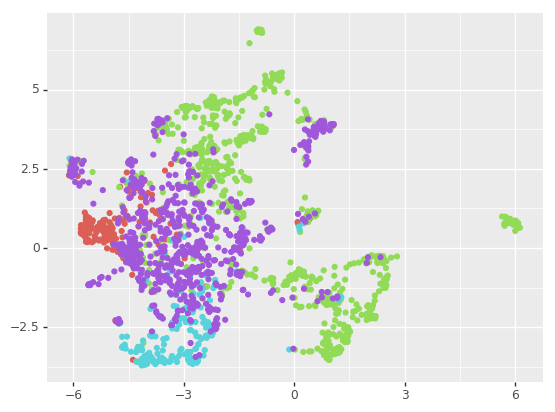

<ggplot: (156231123134)>

In [9]:
gmm = GaussianMixture(n_components=4).fit(news_pca)
labels_gmm = gmm.predict(news_pca)
em['gmm'] = pd.Series(labels_gmm.astype(str))
ggplot(em, aes(x='A',y='B',color='gmm'))+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

In [11]:
print('AMI: ', metrics.adjusted_mutual_info_score(news_labels, labels_gmm))
print('ARI: ', metrics.adjusted_rand_score(news_labels, labels_gmm))

AMI:  0.35263346757562103
ARI:  0.273922059136102


In [13]:
nrep = 15
frem_AMI_20news = np.zeros((nrep, ))
frem_ARI_20news = np.zeros((nrep, ))

for rep in range(nrep):
    theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(4, news_pca, 300, False, 1, 20)
    labels_frem= np.array([i for i in np.argmax(cond_prob_1, axis=1)])

    frem_ARI_20news[rep] = metrics.adjusted_rand_score(label, labels_frem.astype(str))
    frem_AMI_20news[rep] = metrics.adjusted_mutual_info_score(label, labels_frem.astype(str))
    
print(np.median(frem_AMI_20news))
print(np.median(frem_ARI_20news))
print(np.quantile(frem_AMI_20news, 0.25))
print(np.quantile(frem_ARI_20news, 0.25))
print(np.quantile(frem_AMI_20news, 0.75))
print(np.quantile(frem_ARI_20news, 0.75))

convergence:  True
number of iterations:  29


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  29


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  19


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  24


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  20


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  29


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  36


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  22


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  18


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  26


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  24


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  23


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  29


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  37


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


convergence:  True
number of iterations:  24


C:\Users\roizmanv\anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


0.474322172588083
0.5035535433878963
0.4716676733814015
0.5004314648513299
0.4760840920916108
0.5045792205187598


In [12]:
theta_estimated_1, cond_prob_1, delta_mu_1, delta_sigma_1 = FREM(4, news_pca, 250, False, 1, 20)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
convergence:  True
number of iterations:  36


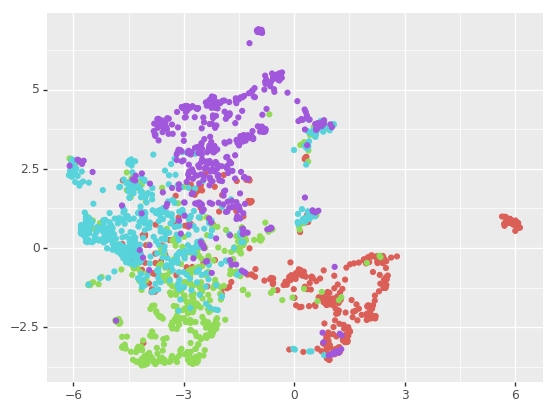

<ggplot: (-9223371880623678215)>

In [14]:
cond_prob = compute_condition_prob_matrix(news_pca, theta_estimated_1)
labels_cg = np.array([i for i in np.argmax(cond_prob, axis=1)])
em['estimated'] = pd.Series(labels_cg.astype(str))
ggplot(em, aes(x='A',y='B',color='estimated'))+geom_point()+ylab("")+xlab("")+ scale_color_discrete(guide=False)

In [15]:
print('AMI: ', metrics.adjusted_mutual_info_score(news_labels, labels_cg))
print('ARI: ', metrics.adjusted_rand_score(news_labels, labels_cg))

AMI:  0.508734793682486
ARI:  0.5445252667468933


C:\Users\roizmanv\miniconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


In [17]:
np.savetxt("news_pca.csv", news_pca, delimiter=",")
np.savetxt("news_labels.csv", news_labels, delimiter=",")

In [20]:
rlabels = pd.read_csv("est_labels_.csv").values[:,1]
print(rlabels)
print('AMI: ', metrics.adjusted_mutual_info_score(news_labels, rlabels))
print('ARI: ', metrics.adjusted_rand_score(news_labels, rlabels))

[2 2 2 ... 4 4 1]
AMI:  0.449635824110494
ARI:  0.4426837718839769
